In [1]:
#!/usr/bin/env python
# coding: utf-8

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Non-Negative Matrix Factorization for Image Compression and Clustering<br>
<br>
This is the Python Jupyter Notebook for the [Medium article on the from scratch implementation of the Non-Negative Matrix Factorization (NNMF) algorithm in Python](https://towardsdatascience.com/non-negative-matrix-factorization-for-image-compression-and-clustering-89bb0f9fa8ee). It illustrates the basic implementation of the algorithm and explores some of its features in the context of <br>
1. Image compression <br>
2. https://github.com/huspark/nonnegative-matrix-factorization/blob/master/mu.py<br>
<br>
As we will do the implementation of the NNMF algorithm ourselves we will only import the basic Python libraries in the first step.

In [3]:
cd /content/drive/MyDrive/Python_Image_Inverse_Problem/NMF

/content/drive/MyDrive/Python_Image_Inverse_Problem/NMF


In [4]:
import numpy as np
from numpy.linalg import lstsq

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

Enable plots inside the Jupyter NotebookLet the<br>
et_ipython().run_line_magic('matplotlib', 'inline')

A detailed explanation of the intuition behind the NNMF algorithm can be found in the accompanying Medium article to this notebook which is why we will keep this part short here. In brief, what we want to achieve in NNMF is to represent any positive, numerical matrix as the product of two lower dimensional matrices. This allows us to 1) reduce the size of an image file and 2) cluster datasets by their most prominent features. So what we want to do is the following: <br>
<br>
$$ V = WH$$<br>
<br>
Where *V* is our original input matrix, e.g. an image, *W* is our feature matrix and *H* contains the weights of the features. This way we can reconstruct *V* from *WH*. <br>
The hard part however is to find *W* and *H*. There are several ways of doing so but here we will stay with the multiplicative update rule derived from the loss function based on the square of the Euclidian distance between *V* and *WH*. <br>
<br>
$$L(V, HW)={\lVert V-WH \rVert}^2$$<br>
<br>
Using this this loss function will give rise to the following update rule for H and W:<br>
<br>
$$H^{n+1}_{[i,j]} \leftarrow H^{n}_{[i,j]} \frac{((W^n)^T V))_{[i,j]}}{((W^n)^T W^n H^n)_{[i,j]}}$$<br>
$$W^{n+1}_{[i,j]} \leftarrow W^{n}_{[i,j]} \frac{(V (H^{n+1})^T))_{[i,j]}}{(W^n H^{n+1} (H^{n+1})^T)_{[i,j]}}$$<br>
<br>
If you want to understand this in more detail I recommend to look into the publication by [Lee and Seung](https://papers.nips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf).<br>
<br>
As you can see from the above *H* and *W* are updated sequentially staring with *H*. The updated *H* is then used to update *W*.  <br>
Translating the update rule from above into Python code we end up with the following two functions:

In [6]:
def als(A, k, num_iter, init_W = None, init_H = None, print_enabled = False):

    if init_W is None:
        W = np.random.rand(np.size(A, 0), k)
    else:
        W = init_W

    if init_H is None:
        np.random.rand(k, np.size(A, 1))
    else:
        H = init_H

    loss = []
    for n in range(num_iter):
		# Update H
		# Solve the least squares problem: argmin_H ||WH - A||
        H = lstsq(W, A, rcond = -1)[0]
		# Set negative elements of H to 0
        H[H < 0] = 0

	    # Update W
		# Solve the least squares problem: argmin_W.T ||H.TW.T - A.T||
        W = lstsq(H.T, A.T, rcond = -1)[0].T

		# Set negative elements of W to 0
        W[W < 0] = 0

        frob_norm = np.linalg.norm(A - W @ H, 'fro')
        #print("iteration " + str(n + 1) + ": " + str(frob_norm))
        loss.append(frob_norm)

    return H, W, loss

That is it. A simple, basic implementation of NNMF with Python from scratch.\<br>
Now let's open an image and see how we can use our NNMF function to compress it. <br>
<br>
## Image compression<br>
<br>
We will load the image with [Matplotlib](https://matplotlib.org/) and then pick only one of the color channels to keep things simple. The two versions of our test image are visualized below.<br>
The original image that is used was created by Autumn Goodman can [be found here](https://unsplash.com/@auttgood).

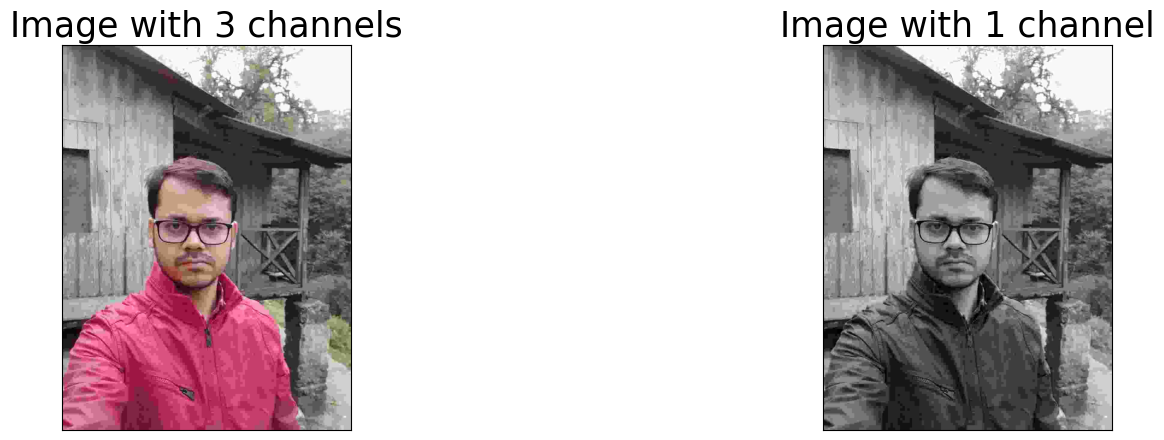

In [7]:
img = plt.imread('./images/Darjeeling_Stay.jpeg')
V = img[:, :, 1] # only use one color channel

# Visualize the image
fig, ax = plt.subplots(1, 2, figsize=[18, 5])

ax[0].imshow(img)
ax[0].set_title('Image with 3 channels', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].set_title('Image with 1 channel',fontsize=25)
ax[1].imshow(V, cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()


Visualize the image

Alright so now that we loaded and prepared our image we can hand it over to our NNMF function. As mentioned above let's also increase the default values a little to see if they make sense.

,W, loss = mu_huspark(V, 20, 1e-8, 300)

In [8]:
H,W, loss = als(V, 30, 300)

By default our NNMF function will also output the loss in each iteration. So before we look at the result in detail we should first check if the algorithm behaves as expected, meaning the loss decreases with every iteration and to verify our choice of default settings.

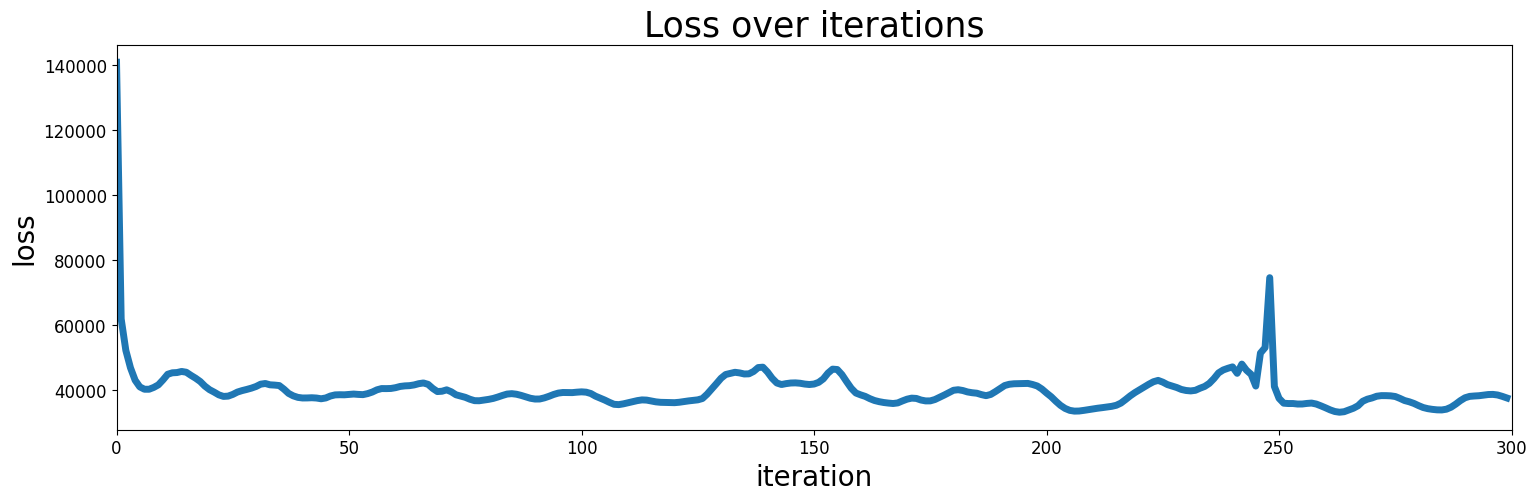

In [9]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(loss, lw=5)
ax.set_title('Loss over iterations', fontsize=25)
ax.tick_params(labelsize=12)
ax.set_xlim(0, 300)
ax.set_xlabel('iteration', fontsize=20)
ax.set_ylabel('loss', fontsize=20)
plt.show()

Ok that looks good. The loss decreases with every iteration until it reaches a minimum. However going for only 100 iterations seems a bit tight as the loss still decreases after 100 iterations. So we better keep it at 300. <br>
<br>
Now the big question(s): How does the reconstructed image look like annd how does the choice of rank influences the result?  <br>
<br>
Let's have a look!

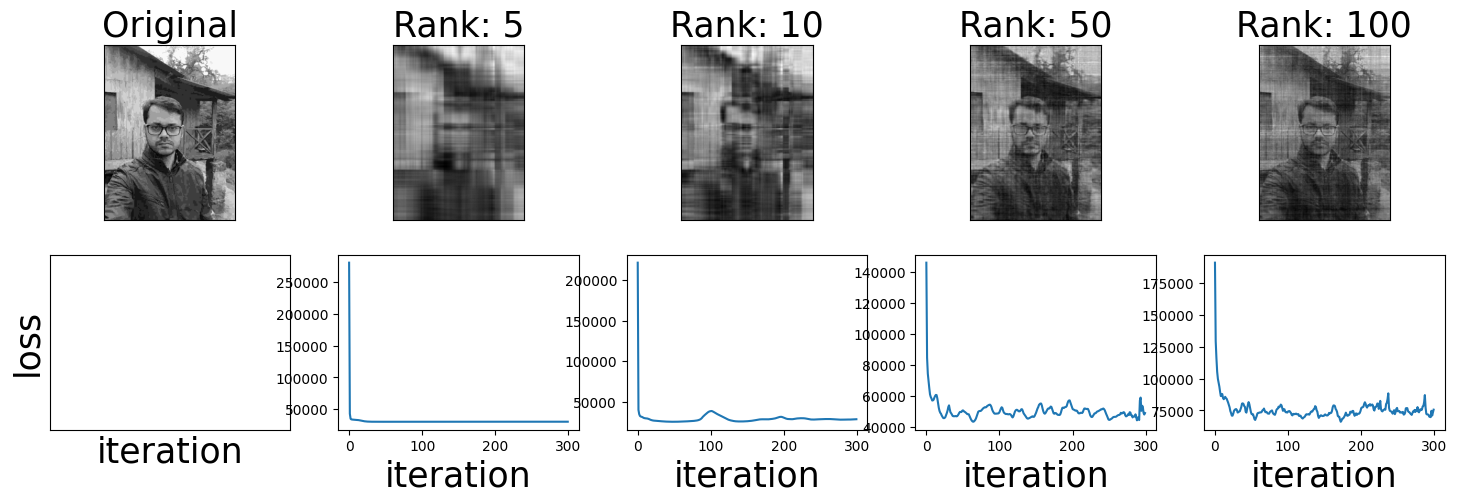

In [11]:
ranks_to_test = [5, 10, 50, 100]

n_plots = len(ranks_to_test) + 1
fig, ax = plt.subplots(2, n_plots, figsize=[18, 5])

# Plot original image as reference
ax[0][0].imshow(V, cmap='gray')
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
ax[0][0].set_title('Original', fontsize=25)

ax[1][0].set_xticks([])
ax[1][0].set_yticks([])
ax[1][0].set_xlabel('iteration', fontsize=25)
ax[1][0].set_ylabel('loss', fontsize=25)

data_points_original = V.shape[0] * V.shape[1]

data_points = []

n = 1
for i in ranks_to_test:

    #H,W, loss = mu_huspark(V, i, 1e-8, 300)
    H,W, loss = als(V, i, 300)


    # Reconstruct the image from W and H
    V_rec = W.dot(H)

    data_points.append((H.shape[0] * H.shape[1]) + (W.shape[0] * W.shape[1]))

    ax[0][n].imshow(V_rec, cmap='gray')
    ax[0][n].set_xticks([])
    ax[0][n].set_yticks([])
    ax[0][n].set_title('Rank: {}'.format(i), fontsize=25)

    ax[1][n].plot(loss)
    ax[1][n].set_xlabel('iteration', fontsize=25)

    n += 1

plt.show()

Plot original image as reference

As expected a low rank of 5 returns a poor image in terms of quality whereas a rank of 50 almost keeps the quality of the original image. With a rank of 100 there is no obvious loss in image quality anymore. However, the dimensionality of *W* and *H* is now higher than the original image. This does not make sense in practice since the representation of the original image is now larger than the original without any gain in image quality.<br>
<br>
But we do not have to go as far as a rank of 100 to inflate the size of the image through "compression". As we can see from the code and figure below also a rank of 50 results in more data points necessary to represent the image than the original matrix.

In[8]:

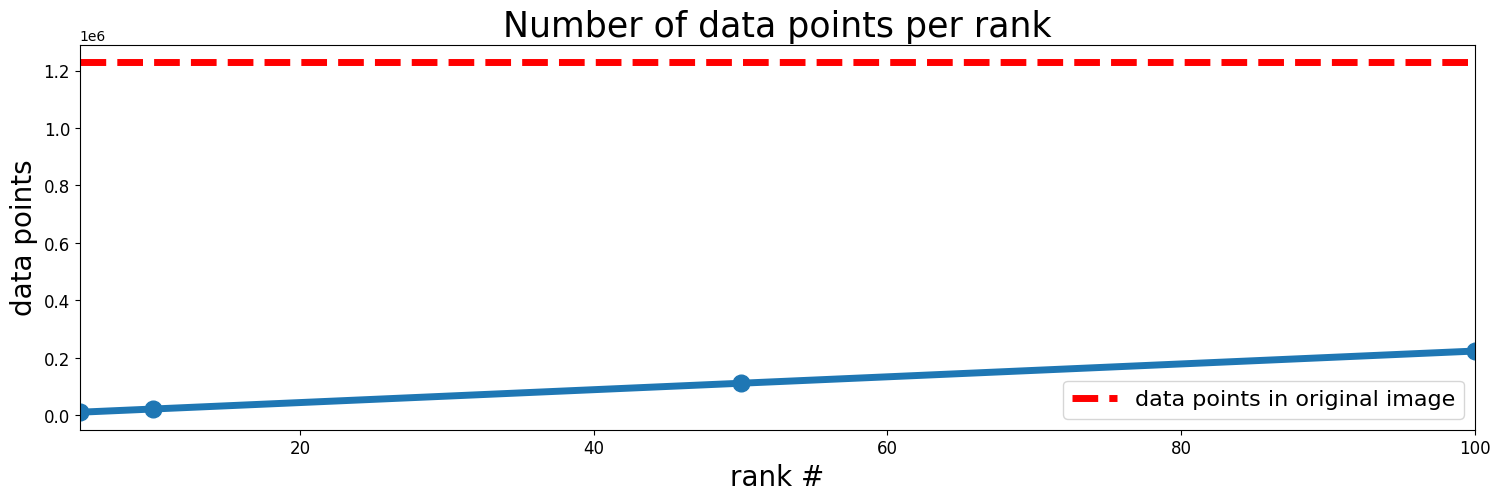

In [12]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5])

ax.plot(ranks_to_test, data_points, marker='o', lw=5, markersize=12)
ax.plot((ranks_to_test[0], ranks_to_test[-1]),
        (data_points_original, data_points_original),
        'r--', lw=5,
        label='data points in original image')

ax.set_title('Number of data points per rank', fontsize=25)
ax.tick_params(labelsize=12)
ax.set_xlim(ranks_to_test[0], ranks_to_test[-1])
ax.set_xlabel('rank #', fontsize=20)
ax.set_ylabel('data points', fontsize=20)
ax.legend(fontsize=16)

plt.show()

Given these insights a rank of 20 looks reasonable. We should have a decent image quality but only half the data points to store. <br>
<br>
To have also a more visual understanding of the NNMF procedure let's plot the matrices *W* and *H* for the rank of 20 together with the resulting image. As we can see *W* has the same number of rows (67) as the resulting image while *H* has the same number of columns (100). While both matrices *W* and *H* look nothing like the original image their matrix product resembles the original image quite well.

In[9]:

, W, _ = mu_huspark(V, 20, 1e-8, 300)

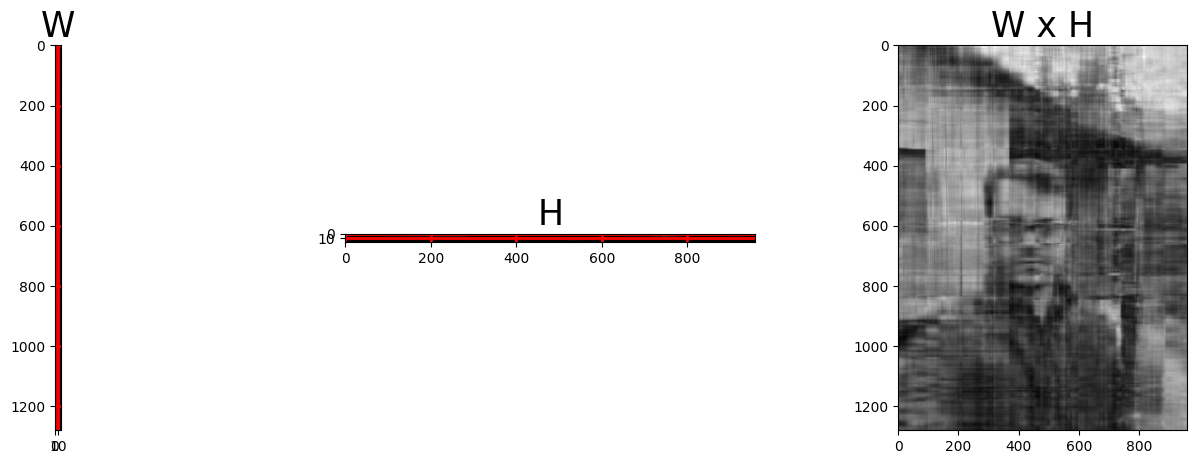

In [13]:
H, W, loss = als(V, 20,  300)

V_rec = W.dot(H)

fig, ax = plt.subplots(1, 3, figsize=[18, 5])

ax[0].imshow(W, cmap='gray')
ax[0].grid(color='r', linestyle='-', linewidth=2)
ax[0].set_title('W', fontsize=25)

ax[1].imshow(H, cmap='gray')
ax[1].grid(color='r', linestyle='-', linewidth=2)
ax[1].set_title('H', fontsize=25)

ax[2].imshow(V_rec, cmap='gray')
ax[2].set_title('W x H', fontsize=25)

plt.show()